In [ ]:
# automatic read in of edf files (multi days) from 1 patient in to 1 big dataset
# start using/considering when we have actual real data files
""""
from os import listdir
from os.path import isfile, join
mypath="test_data_Maastricht" #directory on Christians computer....
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and f[0]!='_']
dataFrame=pd.DataFrame()
for file in onlyfiles:
    labels, timeStamps, data, sr = readData("test_data_Maastricht/" + file)
    alignedTimes, features = extractFeatures(data, timeStamps, 25, 60)
    if dataFrame.shape[0]==0:
        dataFrame=pd.DataFrame(features.T,columns=labels)
        dataFrame.index=alignedTimes
    else:
        df=pd.DataFrame(features.T,columns=labels)
        df.index=alignedTimes
        dataFrame=dataFrame.append(df)
""""

In [43]:
from mne.filter import filter_data
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import pyedflib
import numpy as np
from datetime import timedelta
from scipy.signal import find_peaks_cwt


In [7]:
## define standard variables
featureWindowLength=60 # number of seconds that is used to calculate feature average
esmWindowLength=15 # number of minutes before beep to extract features from

# define source datafiles
leftWristFile="13337_20180203_094429.bdf"
rightWristFile="13337_20180203_094429.bdf"
chestFile="13337_20180203_094429.bdf"

In [6]:
def extractAllSensors(leftWristFile,rightWristFile,chestFile,featureWindowLength=60):
    # Read in the three files
    
    #Process leftWristData
    labels, timeStamps, data, sr = readData(leftWristFile) #run readData ### automated for multiple days?
   
    alignedTimes, leftWristFeatures, labels = extractFeatures(data, timeStamps, sr, featureWindowLength) 
    # extracts feature from just readed leftWristFile -> data (sig_buf) -> leftWristFeatures (return: features)
    
    labels=[l + 'L' for l in labels] #adds L (later R/C) to 'labels':collumn-names of readData
    
    leftWristDF=pd.DataFrame(leftWristFeatures.T,columns=labels,index=alignedTimes)
    # creates pandasDataFrame for leftWrist and fills it with leftWristFeatures(transposed), names collumns with 
    # labels+L and sets alignedTimes (still timeStamps+featureWindowLength) as index.
    
    ### Same for right wrist ###
    labels, timeStamps, data, sr = readData(rightWristFile)
    #Could be right wrist specific or general
    alignedTimes, rightWristFeatures, labels = extractFeatures(data, timeStamps, sr, featureWindowLength)
    labels=[l + 'R' for l in labels]
    rightWristDF=pd.DataFrame(rightWristFeatures.T,columns=labels,index=alignedTimes)
    
    ### Same for chest ###
    labels, timeStamps, data, sr = readData(chestFile)
    #Could be chest specific or general
    alignedTimes, chestFeatures, labels = extractFeatures(data, timeStamps, sr, featureWindowLength)
    labels=[l + 'C' for l in labels]
    chestDF=pd.DataFrame(chestFeatures.T,columns=labels,index=alignedTimes)
    
    return leftWristDF,rightWristDF,chestDF   
## keeps sensors in separate dataframes, to simplify the allignment with ESMdata (possible different first timeStamps
## in different sensors. timeStamps of ESM will be used)

In [9]:
def readData(filename):
    #Extract data
    f = pyedflib.EdfReader(filename) #reading in edf file, not actual data
    sr = f.getSampleFrequencies()[0] #get sample freq out of edf file via edflib
    n = f.signals_in_file #defining nr of channels, f.xxx= property that gives info, std in library
    signal_labels = f.getSignalLabels() # f.xxx() = method from edf library
    sigbufs = np.zeros((n, f.getNSamples()[0])) #numpy zeroes matrix, here 2 dimensional
    for i in np.arange(n): 
        sigbufs[i, :] = f.readSignal(i) #reading in actual data in collums
    #Get starting time; now focusing on timestamps
    startingTime=filename[-19:-4] #extract starting time from file name
    startingTime=pd.to_datetime(startingTime, format='%Y%m%d_%H%M%S', errors='ignore') #function from pandas to convert string into date time
    timeStamps=[] #empty list
    last=startingTime 
    for time in range(f.getNSamples()[0]): #[0] take first value of NSamples
        timeStamps.append(last)
        last=last+pd.Timedelta('%d ms' %(1000/sr)) #%d refers to integer that will be provided after with %...
    f._close()
    return signal_labels, timeStamps, sigbufs, sr
    

In [14]:
def extractFeatures(data, timeStamps, sr, windowLength):
    #Filter data between 4 and 8 Hz
    filtData = filter_data(data, sr, 4,8) #filter_data = function of nme

    #Extract some sort of feature for all windows and corresponding time stamps
    numSamples=data.shape[1]
    
    # Getting number and names of features
    # giving '_' to store in means, do not store this variable; here only interested in tremorNames, not in features
    tremorNames, _ = tremorFeatures(data[:,:windowLength*sr], sr) 
    bradyNames, _ = bradykinesiaFeatures(data[:,:windowLength*sr], sr)
    
    features=np.zeros((len(tremorNames) + len(bradyNames),int(numSamples/(windowLength*sr)))) 
    # create empty matrix again, MNE-package stores data in row-form, so number of rows is number of features
    # this gets transposed in extractAllSensors function
    alignedTimes=[] #empty list
    for i,win in enumerate(range(0,numSamples,windowLength*sr)): 
    #range: gives list with starting points of windows, range(start, end (not considered),stepwidth)
    #enumerate: x=1,2,3,etc; y=sample numbers which are beginnings of windows
        #Average power per channel; mean of squared; later: try sq root/ logarithmic scale??
        
        startOfWin=win
        endOfWin=win+windowLength*sr    
        if i<features.shape[1]:
            #features[:,i]=np.mean(filtData[:,startOfWin:endOfWin]**2,axis=1) #old calculation of means
            #fill designated collumns of empty array 'features', with tremorFeatures and bradykinesiaFeatures
            _,features[:len(tremorNames),i] = tremorFeatures(data[:,startOfWin:endOfWin],sr)
            _,features[len(tremorNames):,i] = bradykinesiaFeatures(data[:,startOfWin:endOfWin],sr)
            # here only interested in features, not in tremor/bradyNames, so for first output '_'
            
            #Timestamp at beginning of each window
            alignedTimes.append(timeStamps[win])
    return alignedTimes, features, tremorNames + bradyNames

In [2]:
def tremorFeatures(windowData,sr):
    gyroChannel={'X':6,'Y':7,'Z':8} 
    # dictionary, assigns and labels info 6/7/8 to X/Y/Z
    freq = np.fft.rfftfreq(featureWindowLength*sr, d=1./sr) 
    #numpy's fast fourier transform, to create spectrogram
    selected=np.logical_and(freq>3.5,freq<7.5)
    #only include freq's between 3.5 - 7.5
    features=[]
    featureNames=[]
    for ch in gyroChannel:
        spec = np.log(np.abs(np.fft.rfft(windowData[gyroChannel[ch],:])))
        #log-scale of absolute present signals (fft) in defined window in each channel (ch)
        features.append(np.sum(spec[selected]))
        #add sum of spec values, using selected freq's; depending on set windowLength
        featureNames.append('BandPower' + ch) #add BandPowerX-Y-Z to names array
    return featureNames, features

In [11]:
def bradykinesiaFeatures(windowData,sr):
    features=[]
    featureNames=[]
    accelerometerChannel={'X':3,'Y':4,'Z':5}
    for ch in accelerometerChannel.keys():
        peaks=find_peaks_cwt(windowData[accelerometerChannel[ch],:],np.arange(40,50))
        features.append(len(peaks))
        featureNames.append('#Movements' + ch)
        features.append(np.mean(np.diff(peaks))/sr)
        featureNames.append('MovementDuration' + ch)
    features.append(np.max(windowData[3:6,:]))
    featureNames.append('MaxMovement')
    return featureNames, features

In [4]:
def alignFeaturesESM(listOfDF,esmFrame,esmColumns,esmWindowLength=15):
    #generic function to add 1/2/3 feature sensor dataframes from readData+extractFeatures into new dataframe which
    # is based on esmFrame to simplify time alignment.
    
    combinedColumns=esmColumns
    for featureFrame in listOfDF:
        combinedColumns= combinedColumns + featureFrame.keys().tolist()
    esmFeatures=pd.DataFrame(columns=combinedColumns) # Create new empty dataframe with feature and esm columns
    # define collumns: start with esmColumns;
    # add all collumn names (featureFrame.keys().tolist() from present DF's in list)
    
    hop=np.mean(np.diff(listOfDF[0].index)) #hop= generic function to extract the time between 2 featuresamples
    # this has to be same as featureWindowLength; by extracting it from data, it is fool-proof.
    #np.diff() gives differences between moment[0] and [1] from index -> timeStamps
    
    for beep in range(esm.shape[0]): #Loop through all the ESM Beeps

        beepTime=esm.index[beep] 
        # Get the corresponding time; defines beepTime as index -> timeStamps (defined in readESM function)
        
        esmData=np.matlib.repmat(esmFrame.iloc[beep][esmColumns],esmWindowLength,1)
        #repeats ESM data values esmWindowLength-times to fill ESMdata over all corresponding sensor-rows
        combined=esmData #creates new DF combined, as start, filled with repeated ESM data
        
        subIndex=[beepTime-hop*t for t in range(esmWindowLength)][::-1]
        #sets timeStamps (in beepTime) in right direction via [::1]
        
        ### now, sensor data is going to be added to combined dataframe (with only esmData so far)
        for featureFrame in listOfDF: #independent on number of featureFrames in list 
        
            timediff = np.min(np.abs(featureFrame.index-esmFrame.index[beep])) 
            # Find corresponding moment for beep time in the sensor data
            if timediff>timedelta(minutes=esmWindowLength):
                # If corresponding time is too far off, remove beep
                #print("Couldn't find corresponding sensor data")
                continue
            pos=np.argmin(np.abs(featureFrame.index-esm.index[beep]))
            # pos -> the smallest time difference with esm.index (timeStamp) in the sensor data
            if pos>esmWindowLength:
                featColumns=featureFrame.keys().tolist() #names of the relevant collumns in featureFrame in listOfDF           
                featData=featureFrame.iloc[pos-esmWindowLength:pos][featColumns].values
                # Get corresponding timestamps of sensor-rows over whole esmWindow, so from [pos-esmWinLen]:[pos]
                
                # Repeat ESM data for each data point in the window ##### already done?
                
                combined=np.concatenate((combined,featData),axis=1)
                #actual adding feature sensor data points (featData) to ESM data in combined dataframe
                
        if combined.shape[1]==len(combinedColumns):
            esmFeatures=esmFeatures.append(pd.DataFrame(combined,columns=combinedColumns,index=subIndex))
                #if number f collumns is correct, add combined values/matrix to empty esmFeatures dataframe
    return esmFeatures

In [12]:
#perform extract features for chest and both wrists; store in l, r, c.
l,r,c = extractAllSensors(leftWristFile,rightWristFile,chestFile,60)

#if one sensor contains >1 edf files per day: manually adjust

Setting up band-pass filter from 4 - 8 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 82 samples (3.280 sec) selected


<ipython-input-1-b0a80631f2bb>:3: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  filtData = filter_data(data, sr, 4,8) #filter_data = function of nme


Setting up band-pass filter from 4 - 8 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 82 samples (3.280 sec) selected


<ipython-input-1-b0a80631f2bb>:3: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  filtData = filter_data(data, sr, 4,8) #filter_data = function of nme


Setting up band-pass filter from 4 - 8 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 82 samples (3.280 sec) selected


<ipython-input-1-b0a80631f2bb>:3: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  filtData = filter_data(data, sr, 4,8) #filter_data = function of nme


In [13]:
l

,BandPowerXL,BandPowerYL,BandPowerZL,#MovementsXL,MovementDurationXL,#MovementsYL,MovementDurationYL,#MovementsZL,MovementDurationZL,MaxMovementL
2018-02-03 09:44:29,1724.682231,1624.113530,1588.073186,7.0,8.853333,4.0,12.880000,10.0,6.186667,1.182653
2018-02-03 09:45:29,1407.006762,1365.836374,1257.050792,9.0,6.390000,7.0,7.806667,7.0,8.386667,1.177038
2018-02-03 09:46:29,1307.690466,1313.000356,1159.945376,7.0,8.260000,7.0,7.626667,6.0,9.888000,0.909207
2018-02-03 09:47:29,1353.720620,1295.786524,1227.733751,9.0,6.620000,6.0,8.344000,8.0,7.188571,0.466323
2018-02-03 09:48:29,1331.118148,1322.752711,1179.578118,6.0,9.872000,6.0,8.272000,5.0,12.710000,1.042024
2018-02-03 09:49:29,1524.533178,1392.639201,1304.731102,8.0,6.485714,3.0,12.800000,7.0,6.780000,0.717795
2018-02-03 09:50:29,1576.932892,1355.370888,1290.905449,8.0,6.440000,6.0,6.688000,8.0,6.325714,0.176519
2018-02-03 09:51:29,1600.181776,1364.585772,1297.360732,7.0,7.386667,7.0,6.733333,8.0,7.194286,0.541032
2018-02-03 09:52:29,1627.083794,1371.356575,1297.527725,8.0,7.131429,5.0,10.350000,7.0,6.380000,0.386242
2018-02-03 09:53:29,1621.887455,1326.622507,1298.517781,8.0,6.268571,6.0,7.808000,8.0,7.028571,0.393323


In [17]:
# Reading ESM excel data, general code
esm = pd.read_excel('r_esm14d.xlsx')
esm['timeStamp']=pd.to_datetime(esm['timeStamp']) # Transform strings containing date/time to datetime objects
esm.index=esm['timeStamp'] # Set datetime objects as the index

columns=['day','beep','stress', 'cheerful', 'relaxed', 'content', 'irritated','down', 'tremor', 'rigid', 'hinder', 'hinder2']
#columns of interest from ESM dataset

In [18]:
### Combining the three feature sets and ESM data

aligned=alignFeaturesESM([l,r,c],esm,columns,esmWindowLength=15)
#calling function to allign all features+ESM

aligned['ConsecutiveBeep'] = (aligned['day']-1)*7 + aligned['beep']
#adding consecutive beep number collumn

#call function, store it in new variable (alignedFeatures) and give variables to use (esmWindowLength is standard 15)
aligned.shape #check .shape of new variable / matrix

aligned = aligned.dropna() #dropping al rows with missing values

aligned.to_csv('totalFeatures.csv') #writing csv file

aligned.to_excel('totalFeatures.xlsx') #writing xlsx file

##Admins-MacBook-Pro-3:~ jeroenhabets$ pip install xlrd (in python terminal)

(90, 43)

In [39]:
# checking/seeing rows/collumns
#aligned[:20:5] # slicing work aligned[start:stop:step]
#aligned.iloc[:10] # iloc function allows to slice lines and collumns
aligned['relaxed'][0:5]

# Visualizing some of our features: (old)
#aligned['stress','BandPowerZC'].plot()

2018-02-03 10:01:00    3
2018-02-03 10:02:00    3
2018-02-03 10:03:00    3
2018-02-03 10:04:00    3
2018-02-03 10:05:00    3
Name: relaxed, dtype: object

In [53]:
######## ANALYSES ###########
#libraries to import
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor


In [45]:
### Simple analysis

# Spearman Correlations
r, p = spearmanr(aligned['stress'],aligned['BandPowerXR'])
print('Spearman correlation of r = %f with a p-value of %f' % (r, p))

Spearman correlation of r = 0.714661 with a p-value of 0.000000


In [47]:
### Use Machine Learning to predict some variable from the esm

# Linear Regression
lr = LinearRegression()
# Fitting the linear regression to the data
lr.fit(aligned[['BandPowerXR','BandPowerYL', '#MovementsXL']].values,aligned['stress'])
# Looking at model parameters
# Regression weights
print('Weights are %f, %f, %f ' % (lr.coef_[0], lr.coef_[1], lr.coef_[2]))
# Intercept
print('Intercept is %f' % lr.intercept_)


# Predict target variable based on input data (should be unseen data)
prediction = lr.predict(aligned[['BandPowerXR','BandPowerYL', '#MovementsXL']].values)

Weights are 0.010902, -0.005863, 0.098696 
Intercept is -3.290468


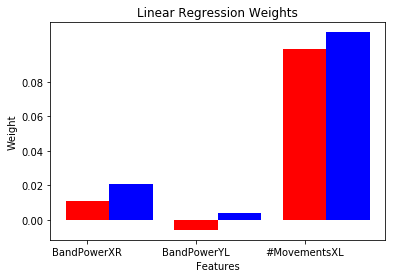

In [48]:
### Data visualization
# Bar plot
fig,ax = plt.subplots()
ax.bar(range(3), lr.coef_,color='r',width=0.4)
ax.bar(np.arange(3)+0.4, lr.coef_+0.01, color='b',width=0.4)
plt.xlabel('Features')
plt.ylabel('Weight')
plt.title('Linear Regression Weights')
plt.xticks(range(3),['BandPowerXR','BandPowerYL', '#MovementsXL'])
plt.yticks(np.arange(0,0.1,0.02))
plt.savefig('weights.png',dpi=60)
plt.show()

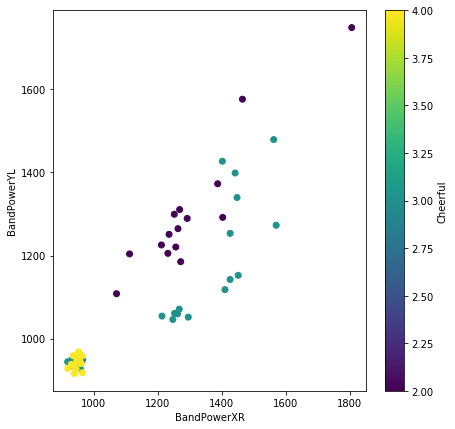

In [63]:
# Scatter Plot
feature1='BandPowerXR'
feature2='BandPowerYL'
# generic coding for different features in scatter plot
fig, ax = plt.subplots(figsize=(7,7))
s1 = ax.scatter(aligned[feature1], aligned[feature2], c=aligned['cheerful'])
plt.xlabel(feature1)
plt.ylabel(feature2)
fig.colorbar(s1,label='Cheerful')
plt.show()

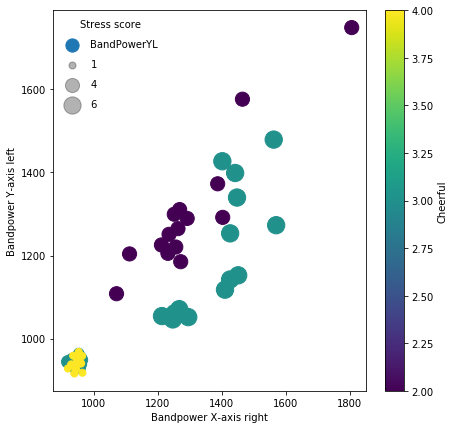

In [181]:
# Scatter Plot with size variable
featureX=aligned['BandPowerXR']
featureY=aligned['BandPowerYL']
colFeature=aligned['cheerful']
sizeFeature=(pd.to_numeric(aligned['stress'], errors='coerce'))
# convert array aligned['stress'] in to floating points to enable size plotting

fig, ax = plt.subplots(figsize=(7,7)) ## why fig,ax,s1
s1 = ax.scatter(featureX, featureY, c=colFeature, s=sizeFeature*50)
plt.xlabel("Bandpower X-axis right")
plt.ylabel("Bandpower Y-axis left")
fig.colorbar(s1,label='Cheerful')

# creating legend
## WHY EXTRA FEATURE2 IN LEGEND?? unknown...
legendScores=[1,4,6]

for s in legendScores:
    ax.scatter([], [], c='k', alpha=0.3, s=s*50,
                label=str(s) )
ax.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Stress score')
#c='k' is color, alpha= transparency

plt.show()

In [ ]:
# Histogram
plt.hist(aligned['#MovementsXR'])

In [50]:
# Principal Component Analysis
def pca(data):
    # Calculate Covariance Matrix
    cov=np.cov(data.T)
    # Calculate Eigenvalues and Eigenvectors
    w, v = np.linalg.eig(cov)
    # Sort them
    s= np.argsort(w)[::-1]
    return v[:,s]

/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


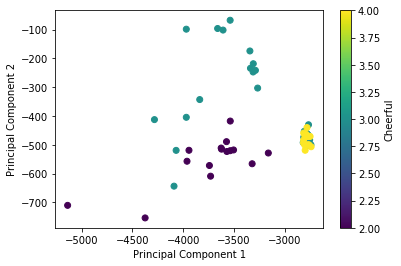

In [60]:
# Could also be done in only sensor/esm spaces
esmEigenVectors = pca(aligned.values.astype(float))
transformedFeatureSpace =np.dot(esmEigenVectors[:,:2].T,aligned.values.astype(float).T).T
s1 = plt.scatter(transformedFeatureSpace[:,0],transformedFeatureSpace[:,1],c=aligned['cheerful'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(s1, label = 'Cheerful')
plt.show()

In [54]:
## It is very easy to use a more powerful Machine Learning algorithm

est = GradientBoostingRegressor()
# Fitting the regression model to our data
est.fit(aligned[['BandPowerXR','BandPowerYL', '#MovementsXL']].values,aligned['stress'])

# Interpreting the model
print(est.feature_importances_)

# Predict target variable based on input data (should be unseen data)
prediction = est.predict(aligned[['BandPowerXR','BandPowerYL', '#MovementsXL']].values)

[0.51900581 0.43825636 0.04273783]


In [55]:
######### Exploring the sensor data

signal_labels, timeStamps, data, sr = readData(leftWristFile)

#filtData = filter_data(data, sr, 4,8)

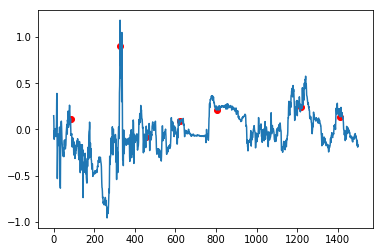

[  83  328  455  624  804 1218 1411]


In [56]:
#Extract some sort of feature for all windows and corresponding time stamps
# Peak detection


channel=3
numSamples=data.shape[1]
windowLength=60

win=0
windowData = data[:,win:win+featureWindowLength*sr]

peaks=find_peaks_cwt(windowData[channel,:],np.arange(40,50))

#Maximum for bradykinesia recognition
mMovement = np.max(windowData[3:6,:])
numberOfPeaks = len(peaks)
averageDuration = np.mean(np.diff(peaks))/sr


plt.plot(windowData[channel,:])
plt.scatter(peaks,windowData[channel,peaks],c='r')
plt.show()
print(peaks)

In [ ]:
### Experiments with Orientation estimation, Above Head Ref System
signal_labels, timeStamps, sigbufs, sr = readData(leftWristFile)

### Transform Gyro data into orientation estimation
from madgwickahrs import MadgwickAHRS
mw = MadgwickAHRS(sampleperiod=1/sr)
euler = np.zeros((3,sigbufs.shape[1]))
for sample in range(sigbufs.shape[1]):
    mw.update_imu(sigbufs[6:,sample],sigbufs[3:6,sample])
    euler[:,sample] = mw.quaternion.to_euler123()
    
# combines acc+gyro data into new data outcome "euler", which gives
# movement in changes in 3 axis compared to gravity (roll,pitch,yaw)

plt.matshow(euler,aspect='auto')
plt.yticks([0,1,2],['Roll', 'Pitch', 'Yaw'])
plt.xlabel('Time in samples')
plt.show()

In [ ]:
# For one bdf file
"""
labels, timeStamps, data, sr = readData("test_data_Maastricht/13337_20180203_094429.bdf")
alignedTimes, features = extractFeatures(data, timeStamps, sr, 60)
dataFrame=pd.DataFrame(features.T,columns=labels)
dataFrame.index=alignedTimes
alignedFeatures=alignFeaturesESM([dataFrame],esm,columns)
alignedFeatures.shape
"""